# Demo

The purpose of this demo is to show that using our implementation of SGHMC we get good uncertainty estimates on out-of-distribution examples, which is the key benefit of Bayesian inference.

In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC

pyro.set_rng_seed(101)

In [2]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

In [3]:
BATCH_SIZE = 500
NUM_EPOCHS = 800
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

### Download MNIST and setup datasets / dataloaders

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale and normalise the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0 
Y_val = train_dataset.targets[val_idx]

X_test = (test_dataset.data / 255.0 - mean) / std
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Load out-of-distribution examples

In [5]:
# load the test letter dataset
letters = ["a","b","c","d","e","f","g","h","i","j"]
x_letters = np.array([np.array(Image.open("data/not-mnist/%s.png"%(l)))
                         for l in letters]).astype(np.float32)# loads letters data
x_letters /= np.max(x_letters, axis=(1,2), keepdims=True)# normalise
x_letters = torch.from_numpy(x_letters)

### Define the Bayesian neural network  model

In [6]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1.):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size]).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution.

In [7]:
LR = 8e-6
MOMENTUM_DECAY = 0.1
RESAMPLE_EVERY_N = 100
NUM_STEPS = 1

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

# full letter posterior predictive
full_letter_predictive = torch.FloatTensor(10, 10)
full_letter_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
        
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
            letter_predictive = None
            for i in range(x_letters.shape[0]):
                letter = x_letters[i, :, :]
                if letter_predictive is None:
                    letter_predictive = predictive(letter)['obs'].to(torch.int64)
                else:
                    letter_predictive = torch.cat((letter_predictive, predictive(letter)['obs'].to(torch.int64)), dim=1)
                    
            for sample in letter_predictive:
                letter_predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_letter_predictive = full_letter_predictive + letter_predictive_one_hot
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.30it/s, lr=8.00e-06]


Epoch [0/50] test accuracy: 0.9412 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.91it/s, lr=8.00e-06]


Epoch [1/50] test accuracy: 0.9423 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.52it/s, lr=8.00e-06]


Epoch [2/50] test accuracy: 0.9423 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.16it/s, lr=8.00e-06]


Epoch [3/50] test accuracy: 0.9427 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.97it/s, lr=8.00e-06]


Epoch [4/50] test accuracy: 0.9419 time: 6.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.54it/s, lr=8.00e-06]


Epoch [5/50] test accuracy: 0.9419 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.77it/s, lr=8.00e-06]


Epoch [6/50] test accuracy: 0.9422 time: 6.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.14it/s, lr=8.00e-06]


Epoch [7/50] test accuracy: 0.9425 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 40.76it/s, lr=8.00e-06]


Epoch [8/50] test accuracy: 0.9426 time: 6.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 40.50it/s, lr=8.00e-06]


Epoch [9/50] test accuracy: 0.9426 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.38it/s, lr=8.00e-06]


Epoch [10/50] test accuracy: 0.9426 time: 6.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.32it/s, lr=8.00e-06]


Epoch [11/50] test accuracy: 0.9424 time: 6.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.30it/s, lr=8.00e-06]


Epoch [12/50] test accuracy: 0.9424 time: 6.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.80it/s, lr=8.00e-06]


Epoch [13/50] test accuracy: 0.9418 time: 6.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.55it/s, lr=8.00e-06]


Epoch [14/50] test accuracy: 0.9421 time: 6.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.28it/s, lr=8.00e-06]


Epoch [15/50] test accuracy: 0.9422 time: 6.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.00it/s, lr=8.00e-06]


Epoch [16/50] test accuracy: 0.9420 time: 6.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.97it/s, lr=8.00e-06]


Epoch [17/50] test accuracy: 0.9423 time: 6.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.85it/s, lr=8.00e-06]


Epoch [18/50] test accuracy: 0.9425 time: 6.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.92it/s, lr=8.00e-06]


Epoch [19/50] test accuracy: 0.9424 time: 6.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.52it/s, lr=8.00e-06]


Epoch [20/50] test accuracy: 0.9425 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.43it/s, lr=8.00e-06]


Epoch [21/50] test accuracy: 0.9424 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.36it/s, lr=8.00e-06]


Epoch [22/50] test accuracy: 0.9425 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.66it/s, lr=8.00e-06]


Epoch [23/50] test accuracy: 0.9429 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.04it/s, lr=8.00e-06]


Epoch [24/50] test accuracy: 0.9431 time: 6.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.27it/s, lr=8.00e-06]


Epoch [25/50] test accuracy: 0.9431 time: 6.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.77it/s, lr=8.00e-06]


Epoch [26/50] test accuracy: 0.9432 time: 6.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.49it/s, lr=8.00e-06]


Epoch [27/50] test accuracy: 0.9436 time: 6.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 35.53it/s, lr=8.00e-06]


Epoch [28/50] test accuracy: 0.9434 time: 6.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.52it/s, lr=8.00e-06]


Epoch [29/50] test accuracy: 0.9437 time: 6.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.14it/s, lr=8.00e-06]


Epoch [30/50] test accuracy: 0.9439 time: 6.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.03it/s, lr=8.00e-06]


Epoch [31/50] test accuracy: 0.9440 time: 6.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.91it/s, lr=8.00e-06]


Epoch [32/50] test accuracy: 0.9441 time: 6.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.04it/s, lr=8.00e-06]


Epoch [33/50] test accuracy: 0.9441 time: 6.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.79it/s, lr=8.00e-06]


Epoch [34/50] test accuracy: 0.9439 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.04it/s, lr=8.00e-06]


Epoch [35/50] test accuracy: 0.9441 time: 6.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 39.34it/s, lr=8.00e-06]


Epoch [36/50] test accuracy: 0.9442 time: 6.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 41.23it/s, lr=8.00e-06]


Epoch [37/50] test accuracy: 0.9444 time: 5.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.11it/s, lr=8.00e-06]


Epoch [38/50] test accuracy: 0.9443 time: 5.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.33it/s, lr=8.00e-06]


Epoch [39/50] test accuracy: 0.9445 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.16it/s, lr=8.00e-06]


Epoch [40/50] test accuracy: 0.9447 time: 7.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 35.41it/s, lr=8.00e-06]


Epoch [41/50] test accuracy: 0.9442 time: 6.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 38.34it/s, lr=8.00e-06]


Epoch [42/50] test accuracy: 0.9443 time: 7.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 33.86it/s, lr=8.00e-06]


Epoch [43/50] test accuracy: 0.9441 time: 7.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 34.42it/s, lr=8.00e-06]


Epoch [44/50] test accuracy: 0.9439 time: 7.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 31.87it/s, lr=8.00e-06]


Epoch [45/50] test accuracy: 0.9437 time: 7.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 37.11it/s, lr=8.00e-06]


Epoch [46/50] test accuracy: 0.9438 time: 6.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 36.80it/s, lr=8.00e-06]


Epoch [47/50] test accuracy: 0.9440 time: 6.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 36.05it/s, lr=8.00e-06]


Epoch [48/50] test accuracy: 0.9441 time: 7.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 37.71it/s, lr=8.00e-06]


Epoch [49/50] test accuracy: 0.9441 time: 6.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 34.49it/s, lr=8.00e-06]


Epoch [50/50] test accuracy: 0.9444 time: 7.48


### Plot out-of-distribution examples

Below we plot the predictions for out-of-distribution examples 

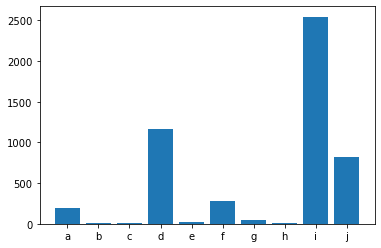

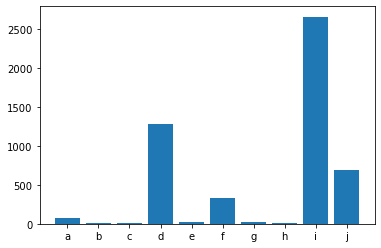

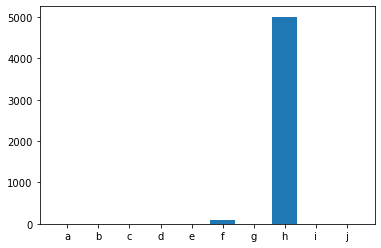

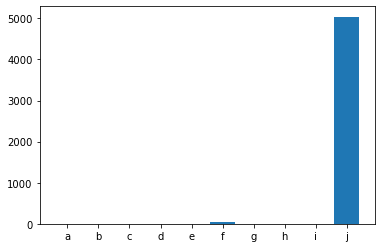

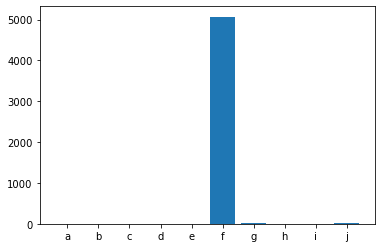

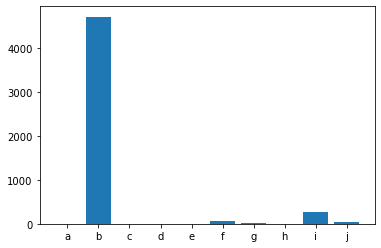

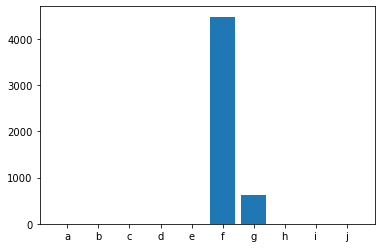

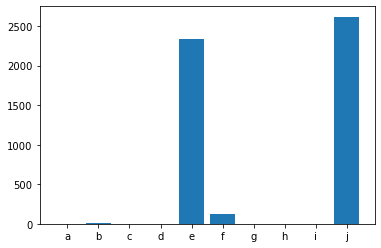

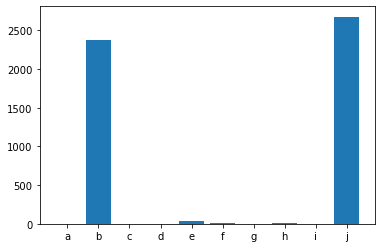

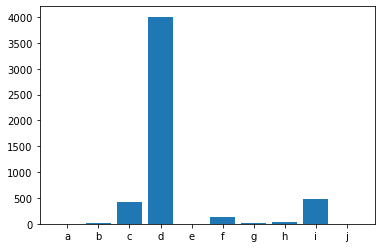

In [17]:
for letter_predictive in full_letter_predictive:
    posterior_dist = letter_predictive.to(torch.int64).numpy()
    plt.bar(letters, posterior_dist) 
    plt.show()